# TUTORIAL #4

https://www.youtube.com/watch?v=KXSLKwADXKI

Measuring the quality of player decision-making and valuing their actions. This tutorial introduces the concept of expected possession value (EPV), describes how to use EPV to quantify the value of passes, and demonstrates how you can combine EPV with pitch control to identify the best passing options available to the player on the ball. [The tutorial 4 script also describes other small changes to the codebase].

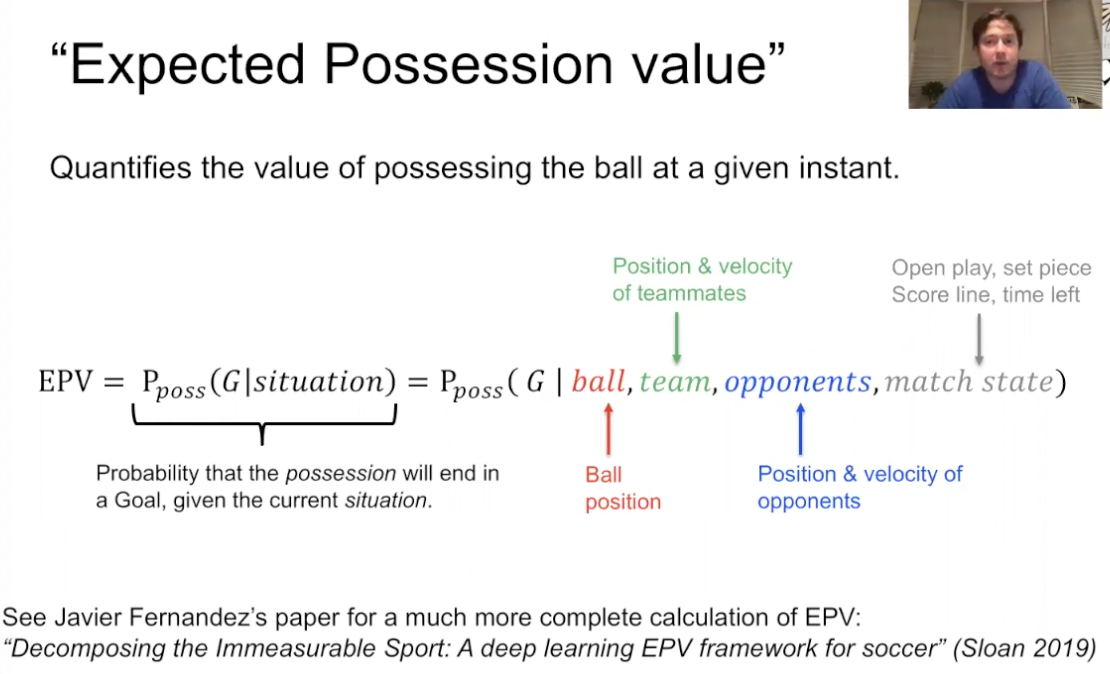

Value is the probability that the team will go on from the current instance and score a goal

# Much simpler possesion value 

Based purely on position of the ball

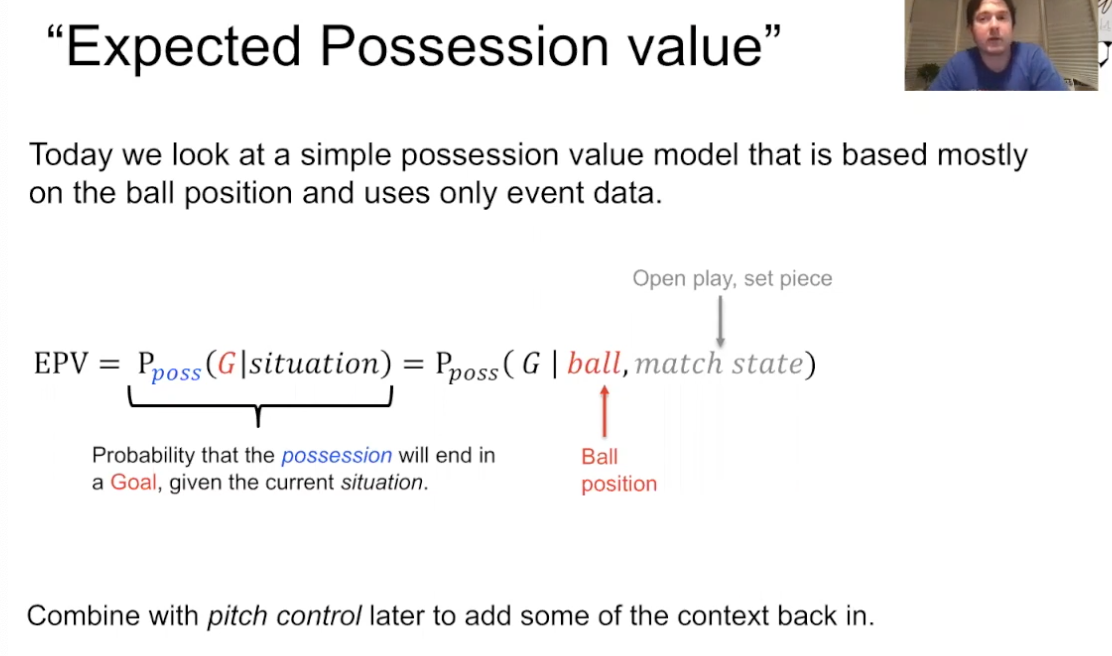

VAEP - look at this work - there are youtube tutorials and videos from this group as well
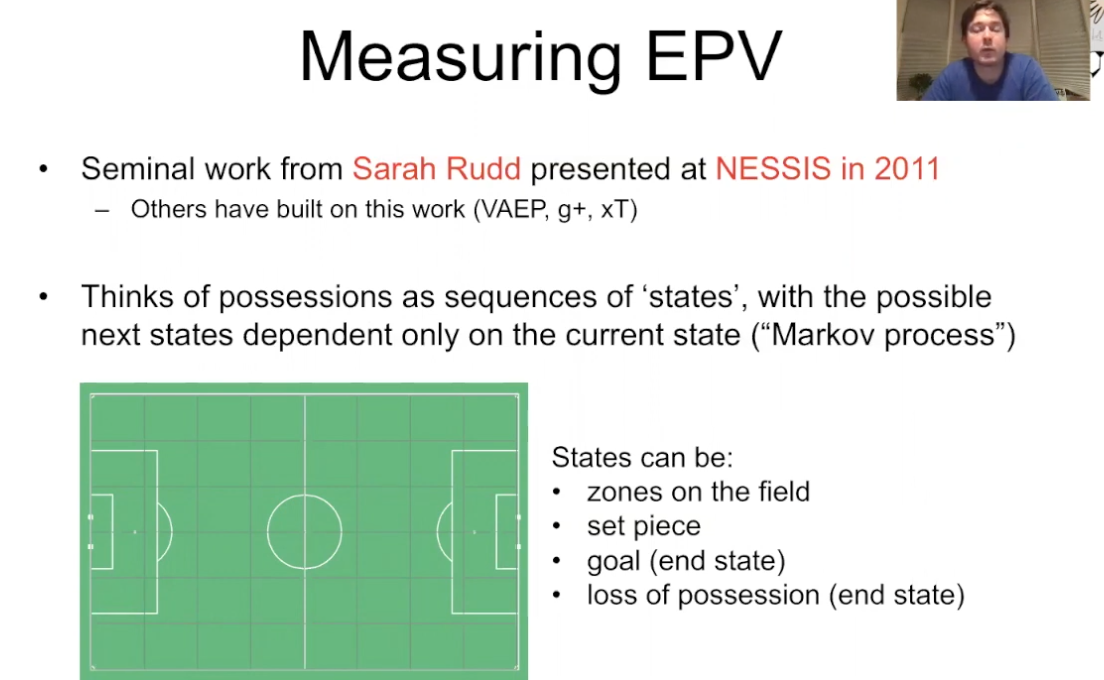

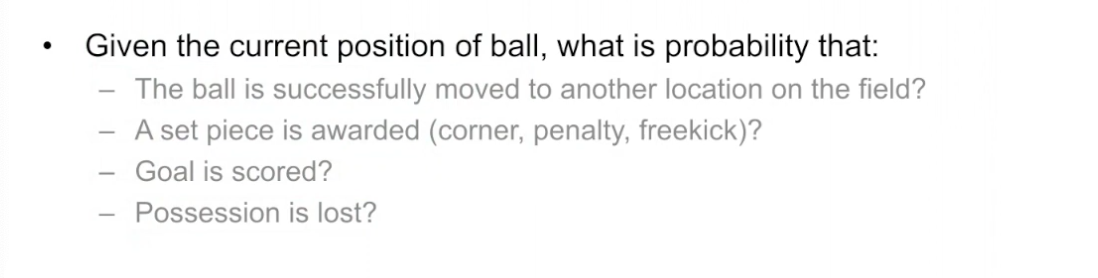

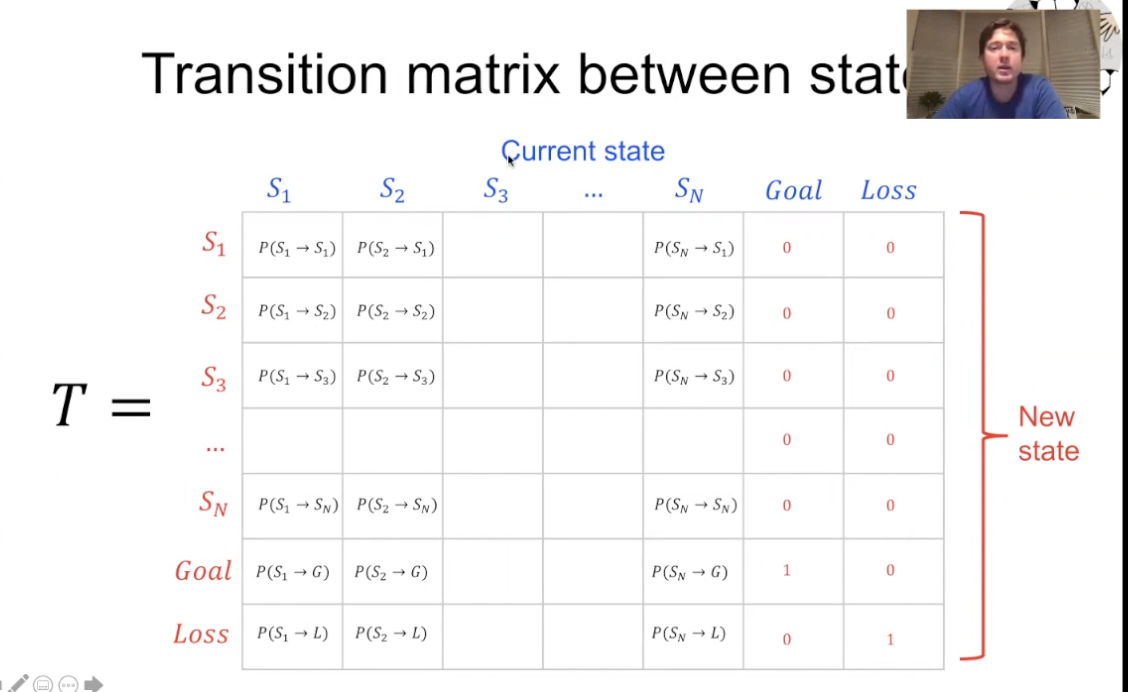

## Probability of moving from your current state to another state - think about the weather problem

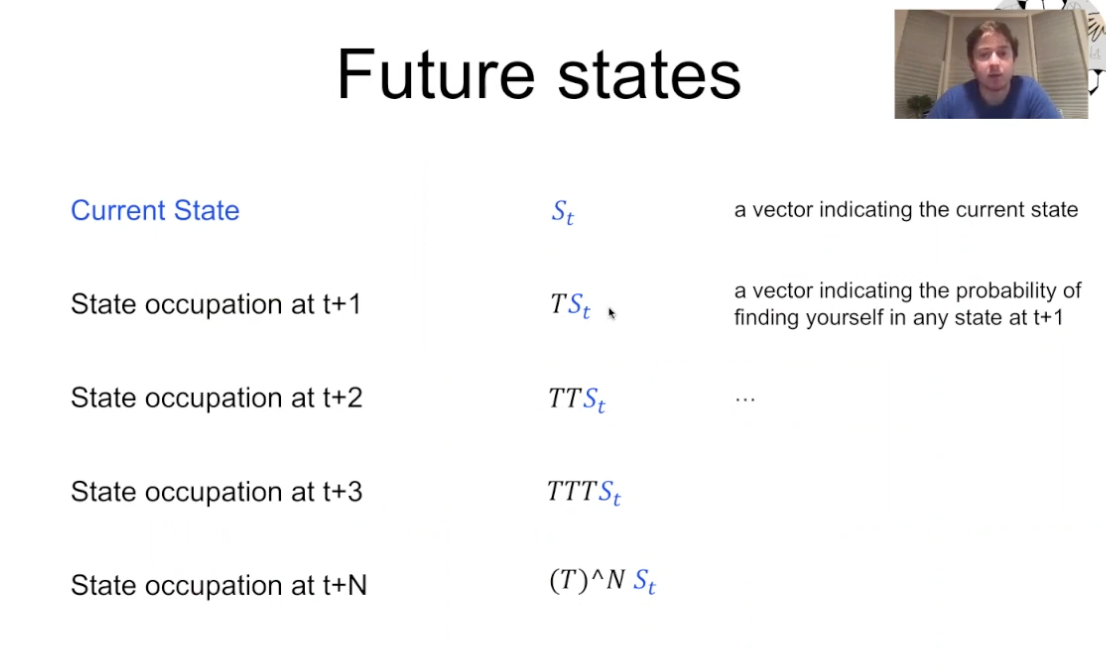

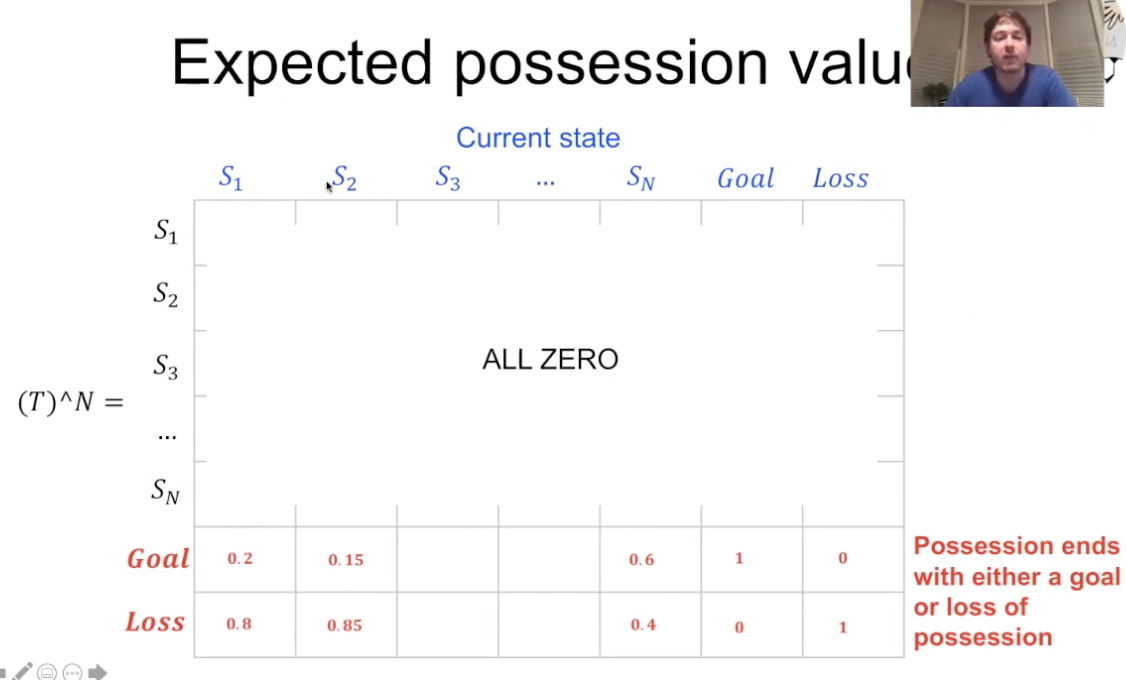

At least one seasons worth of data to build this

Value added by a pass is the EPV in the area where the pass is completed minus the EPV when the pass was made

This allows us to put a value on every action a player takes on the ball (not just shots)

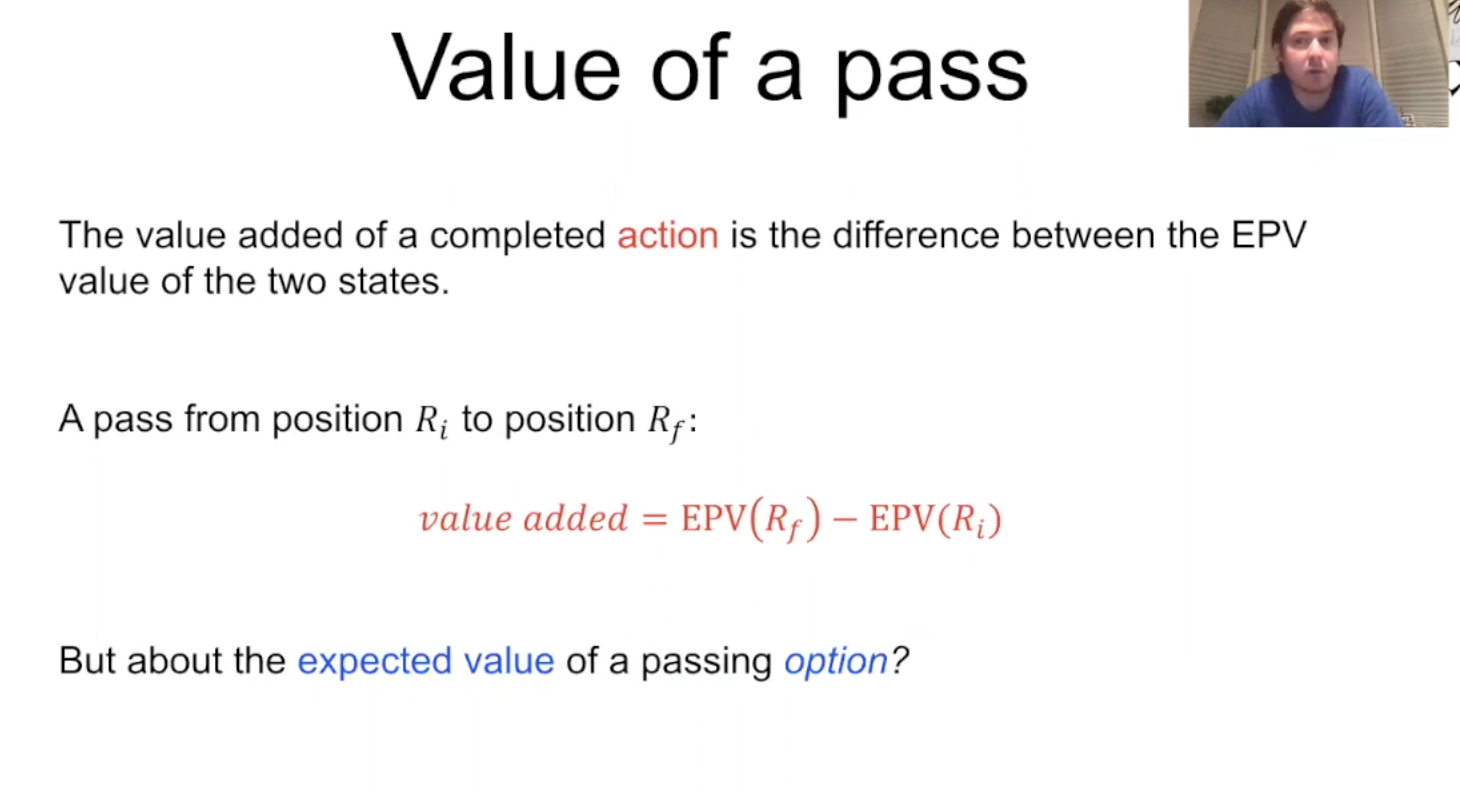


Current value of the possession is not just the EPV - it is the EPV multiplied by the pitch control @ that position!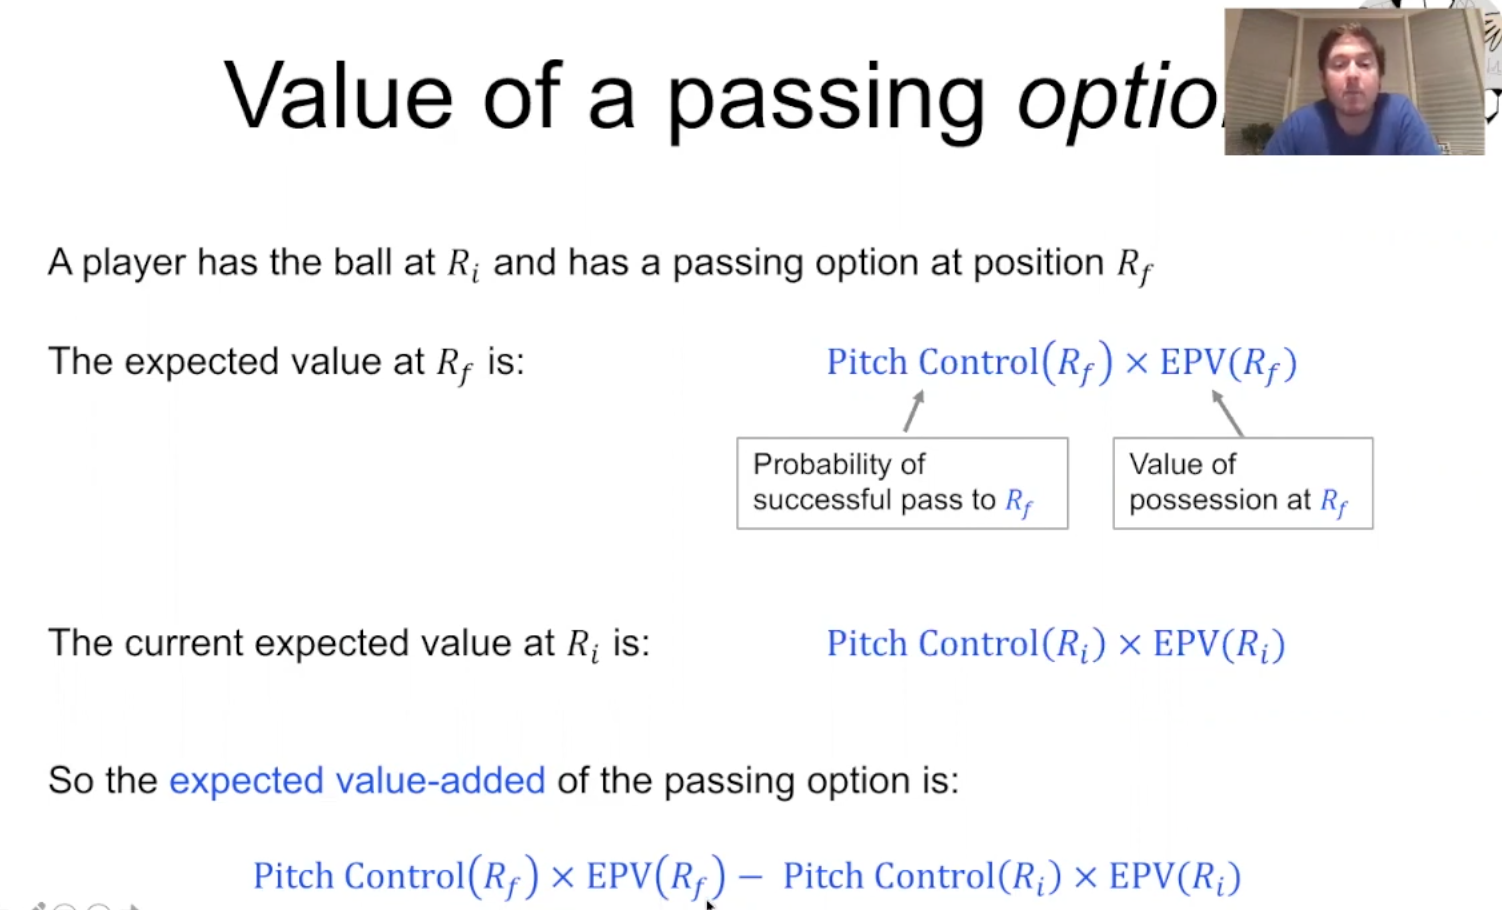

## Python Code

In [ ]:
import sys  
sys.path.insert(0, '/Volumes/Transcend/DataScience/data_bootcamp/data/cap_data')

In [3]:
import Metrica_IO as mio
import Metrica_Viz_CF as mviz
import Metrica_Velocities_CF as mvel
import Metrica_PitchControl as mpc
import Metrica_EPV_CF as mepv

In [4]:
# set up initial path to data
DATADIR = "/Volumes/Transcend/DataScience/data_bootcamp/data/cap_data"
#DATADIR = '/Users/laurieshaw/Documents/Football/Data/TrackingData/Metrica/sample-data-master/data'

game_id = 2 # let's look at sample match 2

In [5]:
# read in the event data
events = mio.read_event_data(DATADIR,game_id)

# read in tracking data
tracking_home = mio.tracking_data(DATADIR,game_id,'Home')
tracking_away = mio.tracking_data(DATADIR,game_id,'Away')

# Convert positions from metrica units to meters (note change in Metrica's coordinate system since the last lesson)
tracking_home = mio.to_metric_coordinates(tracking_home)
tracking_away = mio.to_metric_coordinates(tracking_away)
events = mio.to_metric_coordinates(events)

# reverse direction of play in the second half so that home team is always attacking from right->left
tracking_home,tracking_away,events = mio.to_single_playing_direction(tracking_home,tracking_away,events)

# Calculate player velocities
tracking_home = mvel.calc_player_velocities(tracking_home,smoothing=True)
tracking_away = mvel.calc_player_velocities(tracking_away,smoothing=True)


Reading team: home
Reading team: away


In [6]:
""" *** UPDATES TO THE MODEL: OFFSIDES """
# first get pitch control model parameters
params = mpc.default_model_params()
# find goalkeepers for offside calculation
GK_numbers = [mio.find_goalkeeper(tracking_home),mio.find_goalkeeper(tracking_away)]


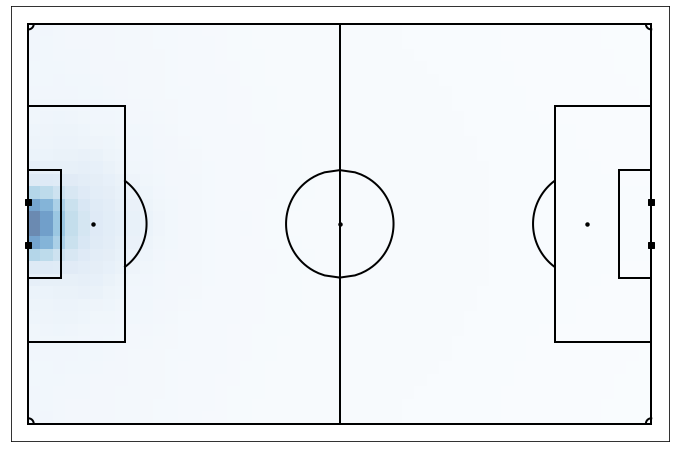

In [7]:
""" *** GET EPV SURFACE **** """
home_attack_direction = mio.find_playing_direction(tracking_home,'Home') # 1 if shooting left-right, else -1
EPV = mepv.load_EPV_grid(DATADIR+'/EPV_grid.csv')
# plot the EPV surface
mviz.plot_EPV(EPV,field_dimen=(106.0,68),attack_direction=home_attack_direction)


(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

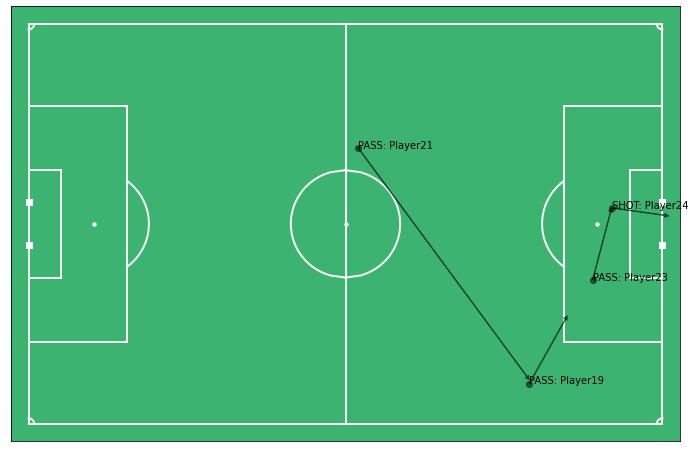

In [8]:
# plot event leading up to first away team goal
mviz.plot_events( events.loc[820:823], color='k', indicators = ['Marker','Arrow'], annotate=True )


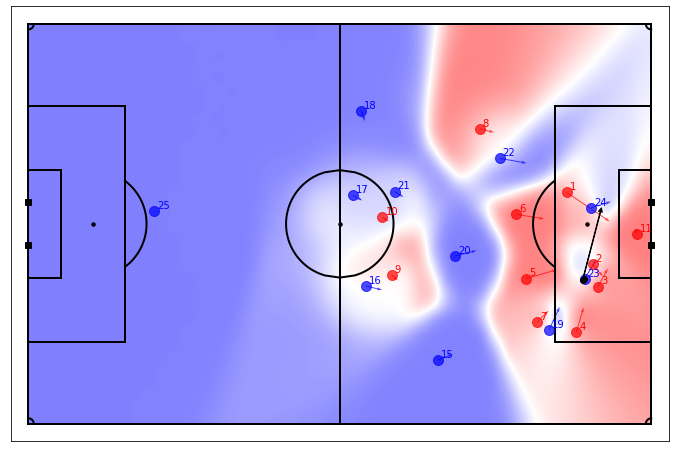

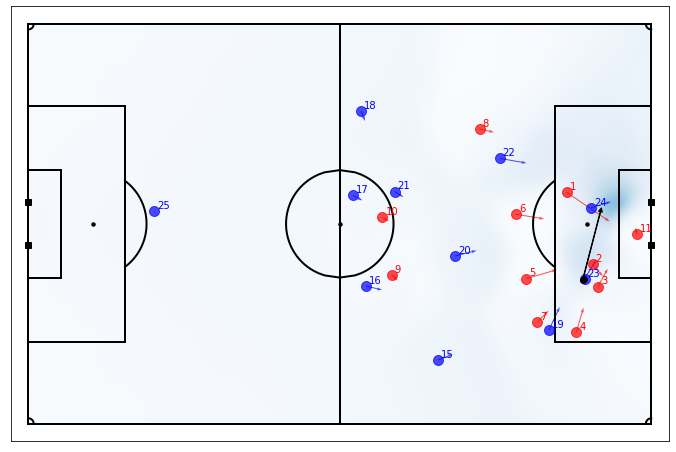

In [11]:
# Calculate value-added for assist and plot expected value surface
event_number = 822 # away team first goal
EEPV_added, EPV_diff = mepv.calculate_epv_added( event_number, events, tracking_home, tracking_away, GK_numbers, EPV, params)
fig.suptitle('Pass EPV added: %1.3f' % EEPV_added, y=0.95 )
mviz.plot_pitchcontrol_for_event( event_number, events,  tracking_home, tracking_away, PPCF, annotate=True)


PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_event(event_number, events, tracking_home, tracking_away, params, GK_numbers, field_dimen = (106.,68.,), n_grid_cells_x = 50, offsides=True)
fig,ax = mviz.plot_EPV_for_event( event_number, events,  tracking_home, tracking_away, PPCF, EPV, annotate=True, autoscale=True )

So it looks like player number 23 chose the best possible pass in that scenario

In [12]:
# first get all shots
shots = events[events['Type']=='SHOT']
home_shots = shots[shots['Team']=='Home']
away_shots = shots[shots['Team']=='Away']

In [13]:
# get all  passes
home_passes = events[ (events['Type'].isin(['PASS'])) & (events['Team']=='Home') ]
away_passes = events[ (events['Type'].isin(['PASS'])) & (events['Team']=='Away') ]


In [14]:
# home team value added
home_pass_value_added = []
for i,pass_ in home_passes.iterrows():
    EEPV_added, EPV_diff = mepv.calculate_epv_added( i, events, tracking_home, tracking_away, GK_numbers, EPV, params)
    home_pass_value_added.append( (i,EEPV_added,EPV_diff ) )
    

In [15]:
# away team value added
away_pass_value_added = []
for i,pass_ in away_passes.iterrows():
    EEPV_added, EPV_diff = mepv.calculate_epv_added( i, events, tracking_home, tracking_away, GK_numbers, EPV, params)
    away_pass_value_added.append( (i,EEPV_added,EPV_diff ) )
    


In [16]:
home_pass_value_added = sorted(home_pass_value_added, key = lambda x: x[1], reverse=True)  
away_pass_value_added = sorted(away_pass_value_added, key = lambda x: x[1], reverse=True)  
    

In [19]:
print("Top 5 home team passes by expected EPV-added")
print(home_pass_value_added[:5])

Top 5 home team passes by expected EPV-added
[(1753, 0.0930427880216463, 0.2252), (1478, 0.08235703576922056, 0.36379999999999996), (197, 0.06266328336978919, 0.2444), (430, 0.04834837878931101, 0.10749999999999998), (851, 0.04490311870837731, 0.1001)]


In [20]:
print("Top 5 away team passes by expected EPV-added")
print(away_pass_value_added[:5])

Top 5 away team passes by expected EPV-added
[(1663, 0.07283823310739922, 0.0378), (961, 0.07003881694848743, 0.1555), (1901, 0.06456906587620734, 0.2474), (822, 0.051630559338968166, 0.0664), (1735, 0.0318064308228498, -0.005600000000000001)]


(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

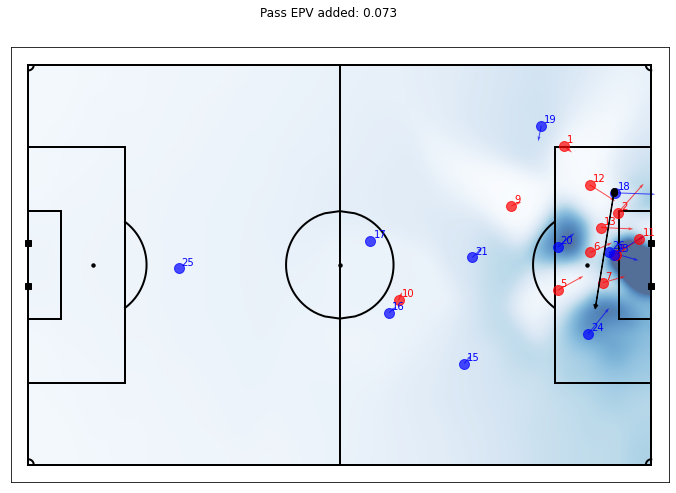

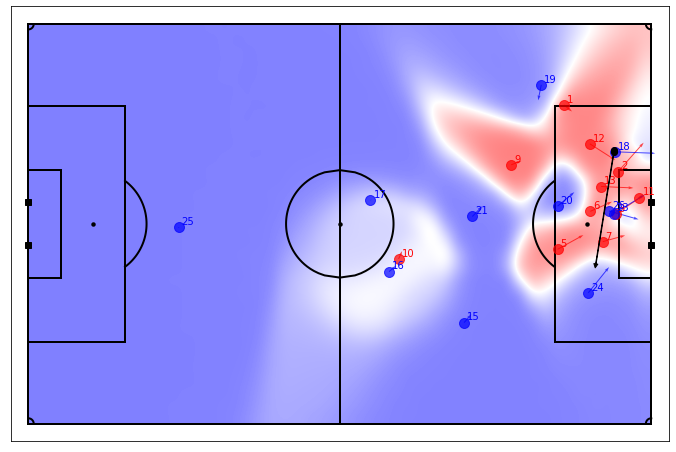

In [21]:
event_number = 1663 # away team assisst to blocked shot
EEPV_added, EPV_diff = mepv.calculate_epv_added( event_number, events, tracking_home, tracking_away, GK_numbers, EPV, params)
PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_event(event_number, events, tracking_home, tracking_away, params, GK_numbers, field_dimen = (106.,68.,), n_grid_cells_x = 50, offsides=True)
fig,ax = mviz.plot_EPV_for_event( event_number, events,  tracking_home, tracking_away, PPCF, EPV, annotate=True )
fig.suptitle('Pass EPV added: %1.3f' % EEPV_added, y=0.95 )
mviz.plot_pitchcontrol_for_event( event_number, events,  tracking_home, tracking_away, PPCF, annotate=True )


(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

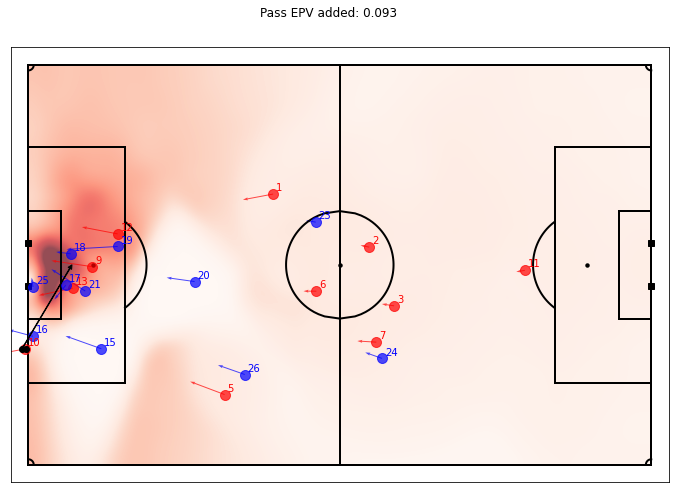

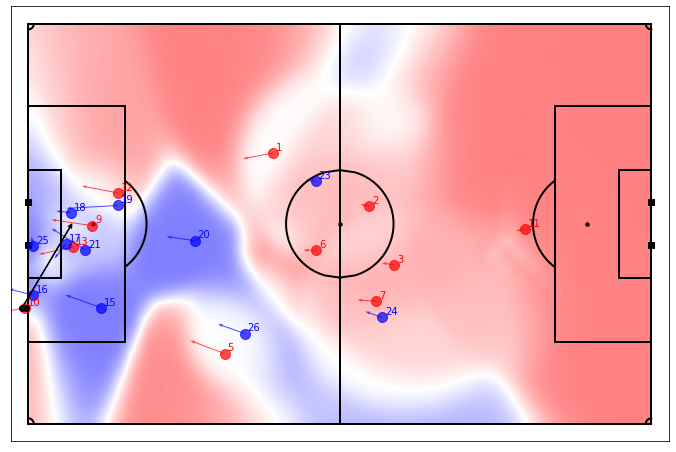

In [22]:
  event_number = 1753 # home team assist to header off target
EEPV_added, EPV_diff = mepv.calculate_epv_added( event_number, events, tracking_home, tracking_away, GK_numbers, EPV, params)
PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_event(event_number, events, tracking_home, tracking_away, params, GK_numbers, field_dimen = (106.,68.,), n_grid_cells_x = 50, offsides=True)
fig,ax = mviz.plot_EPV_for_event( event_number, events,  tracking_home, tracking_away, PPCF, EPV, annotate=True )
fig.suptitle('Pass EPV added: %1.3f' % EEPV_added, y=0.95 )
mviz.plot_pitchcontrol_for_event( event_number, events,  tracking_home, tracking_away, PPCF, annotate=True )


(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

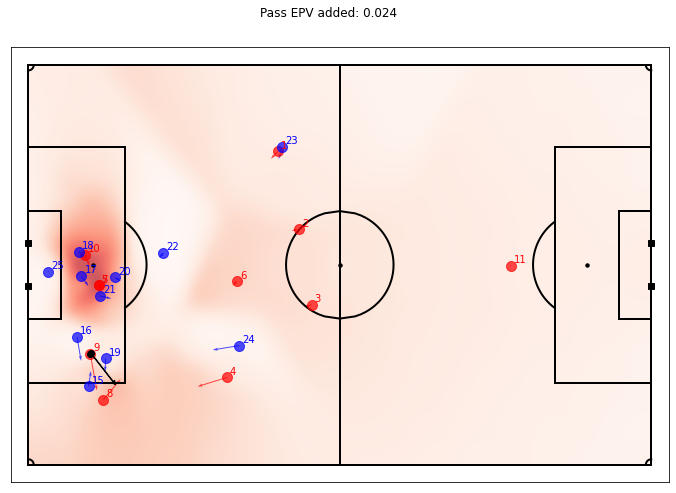

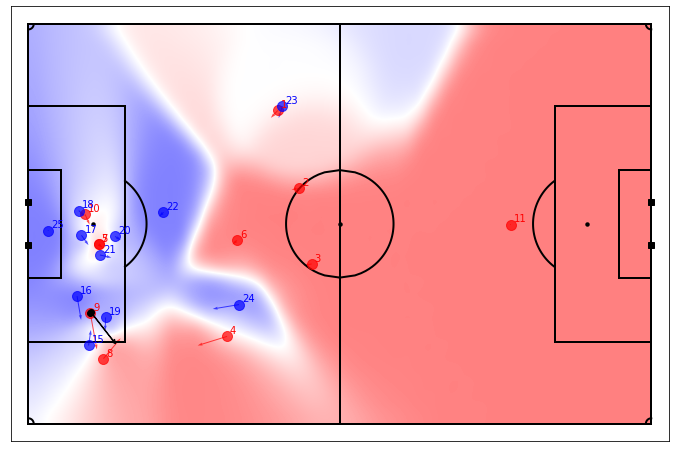

In [23]:
# retaining possession
event_number = 195
EEPV_added, EPV_diff = mepv.calculate_epv_added( event_number, events, tracking_home, tracking_away, GK_numbers, EPV, params)
PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_event(event_number, events, tracking_home, tracking_away, params, GK_numbers, field_dimen = (106.,68.,), n_grid_cells_x = 50, offsides=True)
fig,ax = mviz.plot_EPV_for_event( event_number, events,  tracking_home, tracking_away, PPCF, EPV, annotate=True )
fig.suptitle('Pass EPV added: %1.3f' % EEPV_added, y=0.95 )
mviz.plot_pitchcontrol_for_event( event_number, events,  tracking_home, tracking_away, PPCF, annotate=True )


In [ ]:
'''
 # find maximum possible EPV-added for all home team passes (takes a while to run!)
maximum_EPV_added = []
for i,row in home_passes.iterrows():
    print( 'Event %d' % (i) )
    EEPV_added, EPV_diff = mepv.calculate_epv_added( i, events, tracking_home, tracking_away, GK_numbers, EPV, params)
    max_EEPV_added, target = mepv.find_max_value_added_target( i, events, tracking_home, tracking_away, GK_numbers, EPV, params )
    maximum_EPV_added.append( (i,max_EEPV_added,EEPV_added,EPV_diff))

# sort by the difference between maximum value-added and value-added for the actual pass that was made
# note: some values may be slightly negative because of how the maximum value-added search is performed over a grid
maximum_EPV_added = sorted(maximum_EPV_added,key = lambda x: x[1]-x[2], reverse=True)
'''


You can go and find instances where there was a MUCH better passing option

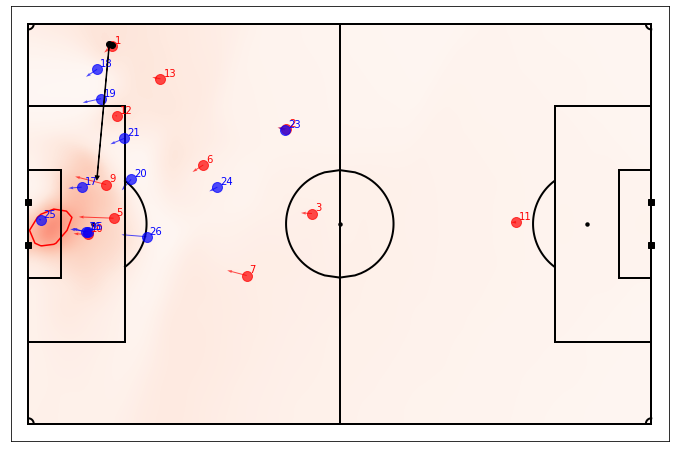

In [24]:
# assist example
event_number = 1680
PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_event(event_number, events, tracking_home, tracking_away, params, GK_numbers, field_dimen = (106.,68.,), n_grid_cells_x = 50, offsides=True)
fig,ax = mviz.plot_EPV_for_event( event_number, events,  tracking_home, tracking_away, PPCF, EPV, annotate=True, autoscale=True, contours=True )


## Plotting 3 examples of common situtation
A long cross field passes have a large EPV improvement over the pass that was chosen. Identifies area of improvement

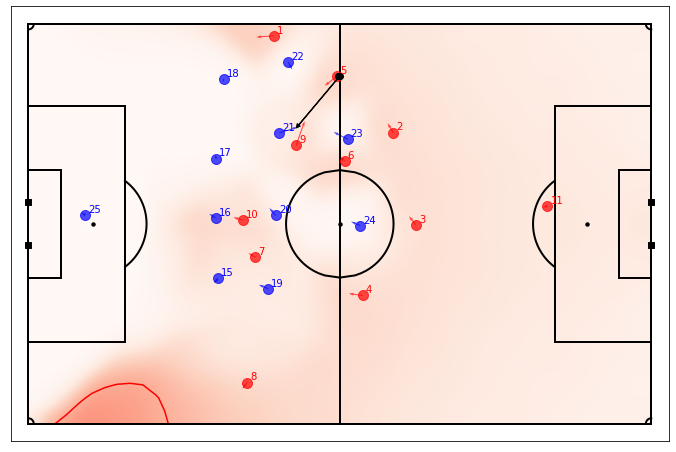

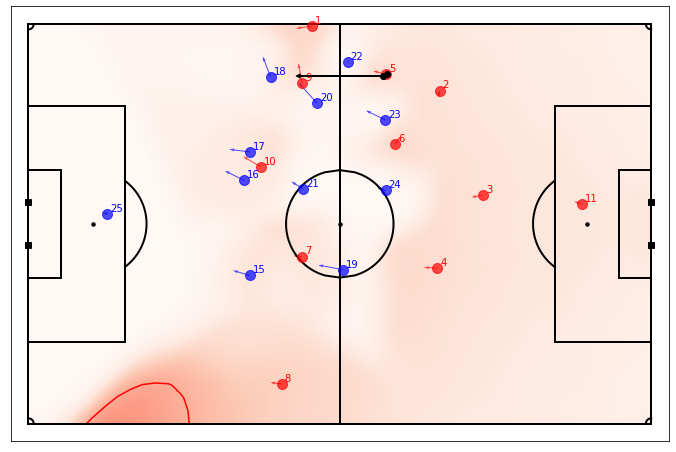

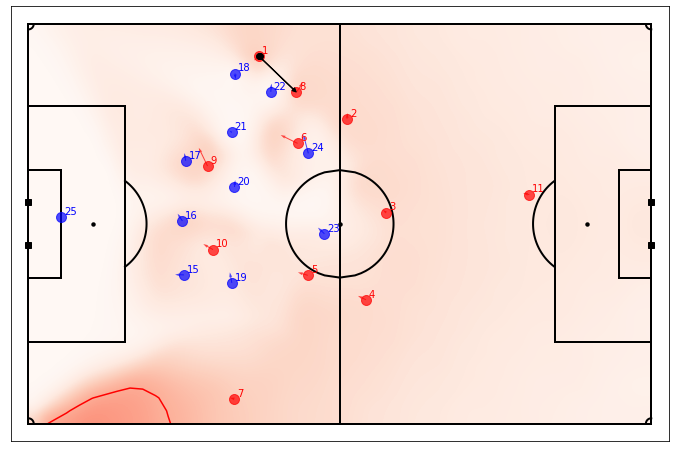

In [25]:
# cross-field passes
examples = [403,68,829]
for event_number in examples:
    PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_event(event_number, events, tracking_home, tracking_away, params, GK_numbers, field_dimen = (106.,68.,), n_grid_cells_x = 50, offsides=True)
    fig,ax = mviz.plot_EPV_for_event( event_number, events,  tracking_home, tracking_away, PPCF, EPV, annotate=True, autoscale=True, contours=True )
     
    

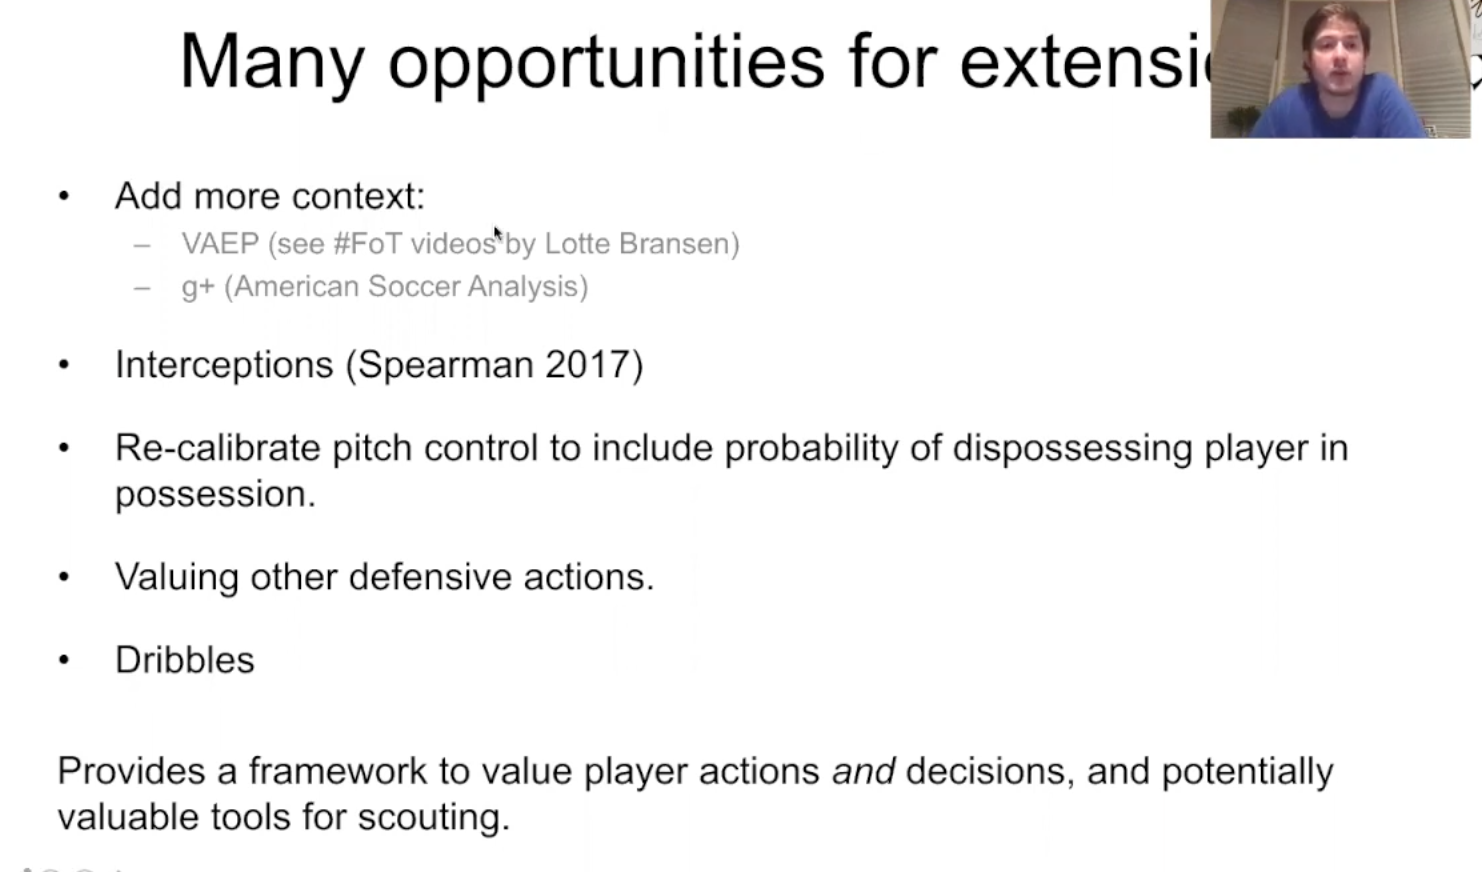